# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [2]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/hyperparameter_optimization"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
verbosity = 1
backend_name = "tensorflow"
computation = "gpu"
outdir = Path(os.path.normpath(os.path.join(run_dir, f"smac_vae_{backend_name}_{computation}")))

time_step(message="Setup loaded", verbosity=verbosity)

X = read_data(data_dir, verbosity=verbosity)

Setup loaded (0.007992982864379883s)
Data loaded (6.610816955566406s)


## Training

In [3]:
# On cluster


In [43]:
backend_name = "tensorflow"
computation = "cpu"
name = "tied_cos_fin" # "tied_fin"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path(os.path.normpath( os.path.join("/mnt/d/runs/VAE/training", project)))

In [44]:
model = keras.saving.load_model(os.path.join(outdir, f"{project}_best.keras"), custom_objects=None, compile=True, safe_mode=True)

/home/josua/miniconda3_linux/envs/VAE/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 29 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [45]:
model.summary()

Model: "fia_vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │   619,126,375 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │             0 │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │   619,952,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,156,002 (4.62 GB)

 Trainable params: 620,078,000 (2.31 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 620,078,002 (2.31 GB)

## Reconstruction

In [46]:
reconstructed_data = pd.DataFrame( model(X).numpy() )

### Show model

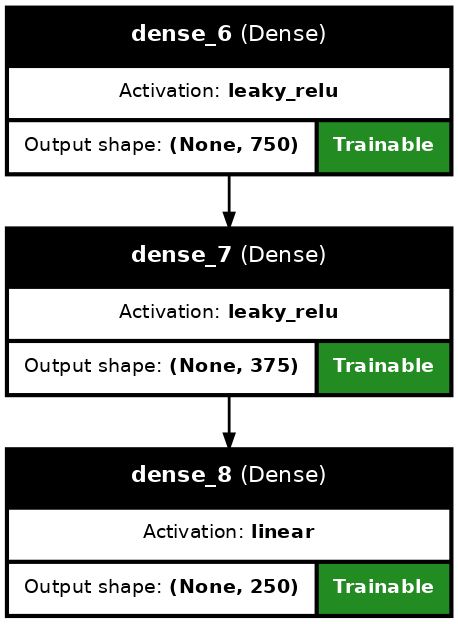

In [74]:
model_plot = keras.utils.plot_model( model.get_layer(index=2), show_shapes=True, show_dtype=False, show_layer_names=True,
                                     rankdir="TB", expand_nested=True, dpi=100, to_file="../../reports/model.png",
                                     show_layer_activations=True, show_trainable=True )
model_plot

## Plot training

In [48]:
history = pd.read_csv(os.path.join(outdir, f"{project}.history.tsv"), sep="\t", index_col="Unnamed: 0")
history

,kl_loss,loss,reconstruction_loss,val_kl_loss,val_loss,val_reconstruction_loss
0,0.006967,0.930124,0.922066,9.025335e-04,0.910647,0.909744
1,0.002158,0.920239,0.917892,6.129742e-04,0.905817,0.905204
2,0.000471,0.914519,0.913988,9.325147e-05,0.901568,0.901475
3,0.000091,0.909507,0.909407,8.523464e-06,0.894435,0.894427
4,0.000020,0.904130,0.904111,7.152557e-07,0.889003,0.889002
...,...,...,...,...,...,...
95,0.000015,0.425985,0.425970,1.108646e-05,0.439675,0.439664
96,0.000023,0.424132,0.424106,9.536743e-06,0.436409,0.436400
97,0.000028,0.420626,0.420596,1.478195e-05,0.436199,0.436184
98,0.000033,0.420545,0.420511,1.585484e-05,0.433670,0.433654


In [49]:
training_losses = history[[col for col in history.columns if not col.startswith("val")]]
validation_losses = history[[col for col in history.columns if col.startswith("val")]]

## Plot results

In [50]:
# reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")

In [62]:
plot_df = pd.DataFrame(reconstructed_data.loc[1].values / 100, index=X.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(X.iloc[1].values, index=X.columns, columns=["inty"]).reset_index()

In [63]:
mae = np.mean( np.abs((plot_df_2["inty"] - plot_df["inty"])) )
ae = np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) )

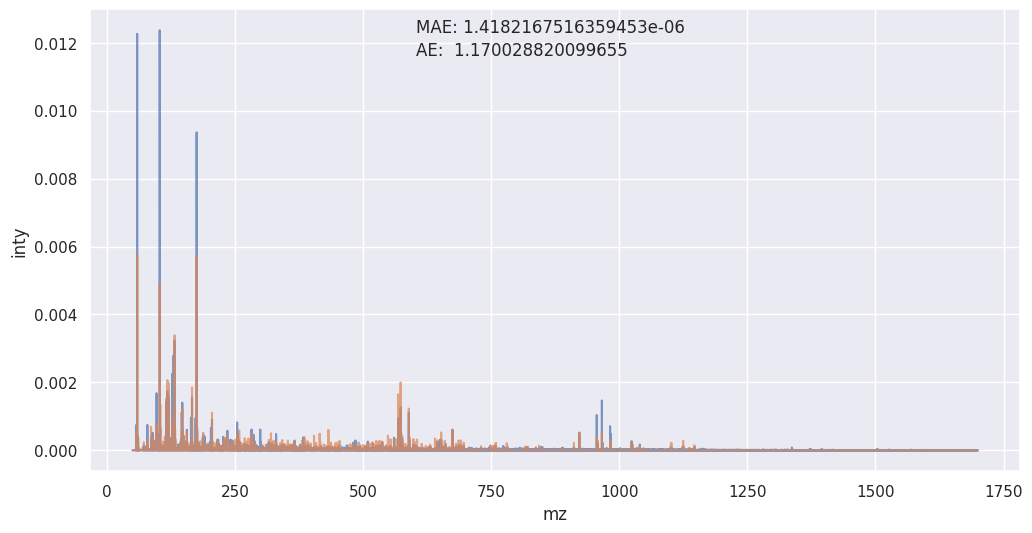

In [64]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.35, 0.95), xycoords='axes fraction')
plt.annotate(f"AE:  {ae}", xy=(0.35, 0.90), xycoords='axes fraction')
plt.show()

(965.9, 966.1)

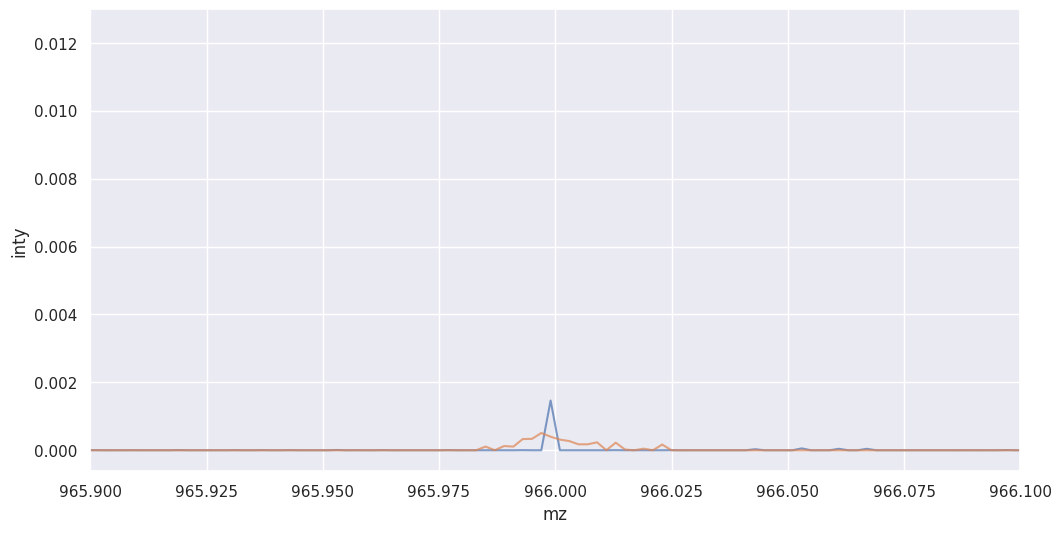

In [65]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(965.9, 966.1)

(-0.0001, 0.003)

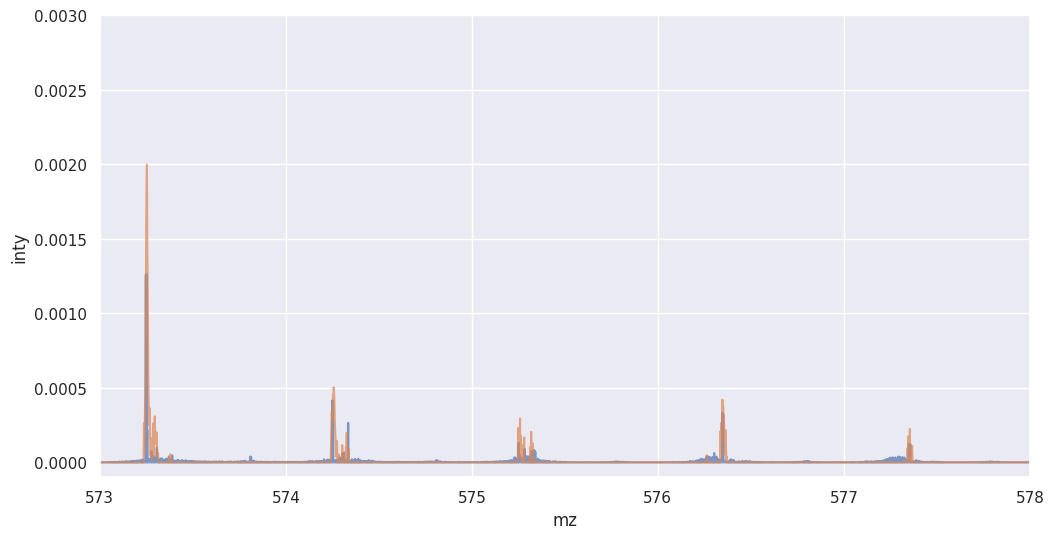

In [66]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

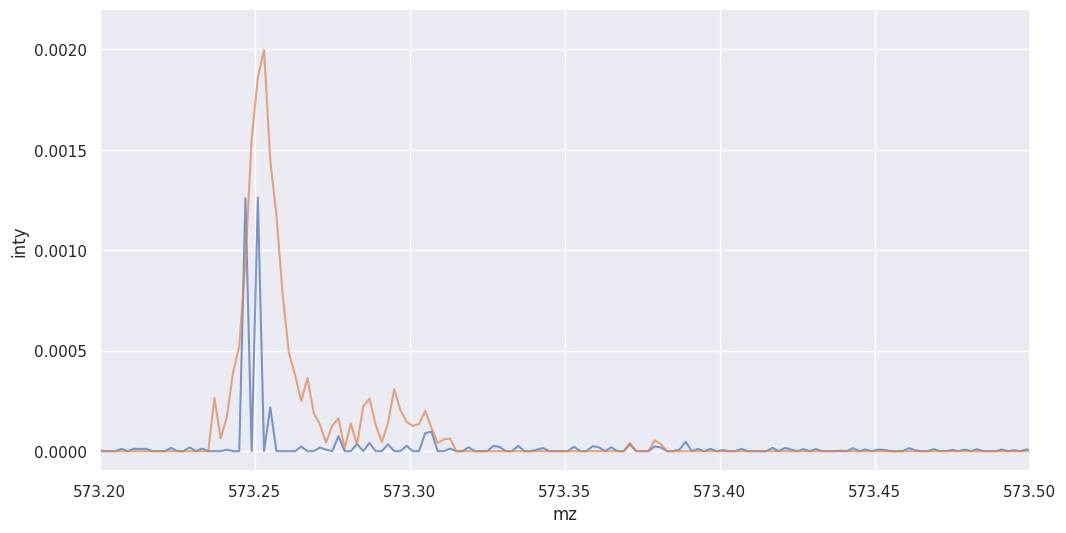

In [67]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [68]:
vae_enc = pd.DataFrame( model.encode_mu(X) )
vae_enc

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,9.833220e-07,-0.000127,-0.000005,0.000069,0.000155,-3.092226e-06,0.000020,0.000057,-0.000040,-0.000003,...,-0.000103,-0.000052,-0.000066,-0.000067,-0.000007,0.000038,-0.000030,-0.000176,-0.000012,-0.000023
1,4.444264e-07,-0.000130,-0.000007,0.000071,0.000152,-6.386672e-07,0.000018,0.000056,-0.000038,-0.000004,...,-0.000103,-0.000051,-0.000067,-0.000066,-0.000005,0.000036,-0.000027,-0.000174,-0.000013,-0.000025
2,4.758349e-07,-0.000132,-0.000007,0.000071,0.000151,8.780698e-07,0.000018,0.000055,-0.000037,-0.000004,...,-0.000104,-0.000052,-0.000067,-0.000066,-0.000005,0.000036,-0.000026,-0.000174,-0.000013,-0.000025
3,4.975082e-07,-0.000131,-0.000007,0.000070,0.000153,-1.238986e-07,0.000019,0.000055,-0.000038,-0.000004,...,-0.000103,-0.000052,-0.000066,-0.000066,-0.000006,0.000037,-0.000027,-0.000175,-0.000012,-0.000024
4,6.843184e-07,-0.000130,-0.000006,0.000070,0.000153,-1.026508e-06,0.000020,0.000055,-0.000039,-0.000003,...,-0.000103,-0.000053,-0.000066,-0.000066,-0.000007,0.000038,-0.000028,-0.000176,-0.000012,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-2.691831e-07,-0.000130,-0.000006,0.000070,0.000153,4.651884e-08,0.000020,0.000055,-0.000039,-0.000004,...,-0.000103,-0.000053,-0.000066,-0.000067,-0.000006,0.000038,-0.000028,-0.000176,-0.000012,-0.000024
64,4.144022e-08,-0.000131,-0.000007,0.000071,0.000153,2.484903e-07,0.000018,0.000055,-0.000037,-0.000004,...,-0.000103,-0.000052,-0.000066,-0.000065,-0.000005,0.000036,-0.000026,-0.000174,-0.000013,-0.000024
65,1.038079e-07,-0.000129,-0.000007,0.000070,0.000153,-3.647347e-07,0.000020,0.000055,-0.000039,-0.000004,...,-0.000103,-0.000053,-0.000066,-0.000066,-0.000007,0.000038,-0.000028,-0.000177,-0.000012,-0.000024
66,3.981662e-06,-0.000130,-0.000005,0.000072,0.000154,-1.031080e-05,0.000016,0.000058,-0.000036,0.000006,...,-0.000101,-0.000049,-0.000066,-0.000066,-0.000006,0.000038,-0.000031,-0.000177,-0.000011,-0.000024


In [69]:
vae_enc.to_csv( os.path.join("/mnt/d/runs/VAE/results", "encoded_mu_tied_cos.tsv"), sep="\t" )